In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.stattools import acf, pacf

In [2]:
df_price = pd.read_csv('SPY-2.csv', parse_dates=['Date'])

In [3]:

df_price.set_index('Date', inplace=True)
df_price['Log_Return'] = np.log(df_price['Adj Close'] / df_price['Adj Close'].shift(1))
df_price['Abs_Return'] = df_price['Adj Close']- df_price['Adj Close'].shift(1)
df_price.drop(['Open', 'High', 'Low', 'Close','Volume'], axis=1, inplace=True)

Text(0,0.5,'Log Return')

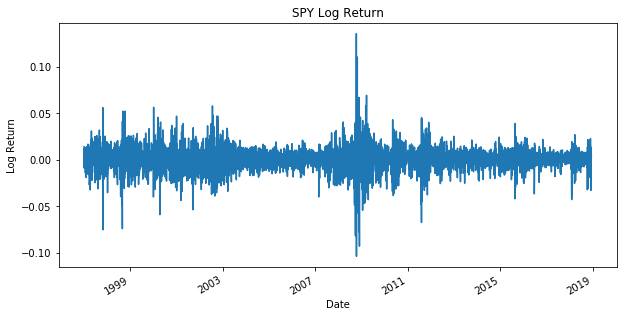

In [4]:
ax = df_price['Log_Return'].plot(figsize=[10, 5], title='SPY Log Return')
ax.set_ylabel('Log Return')


Text(0,0.5,'Abs Return')

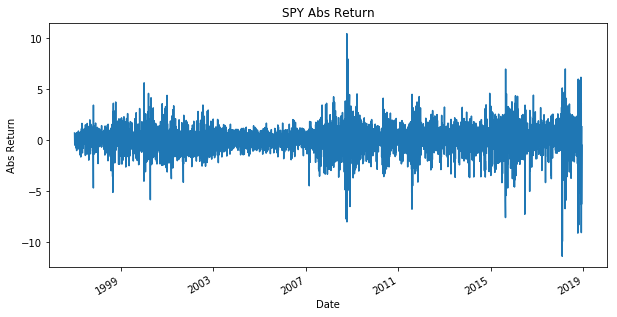

In [5]:
bx = df_price['Abs_Return'].plot(figsize=[10, 5], title='SPY Abs Return')
bx.set_ylabel('Abs Return')

In [6]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        ts_ax.set_title('Time Series Analysis Plots\n Lags={0:.0f}\n Dickey-Fuller: p={1:.5f}'.format(lags,p_value))
        plt.tight_layout()


MissingDataError: exog contains inf or nans

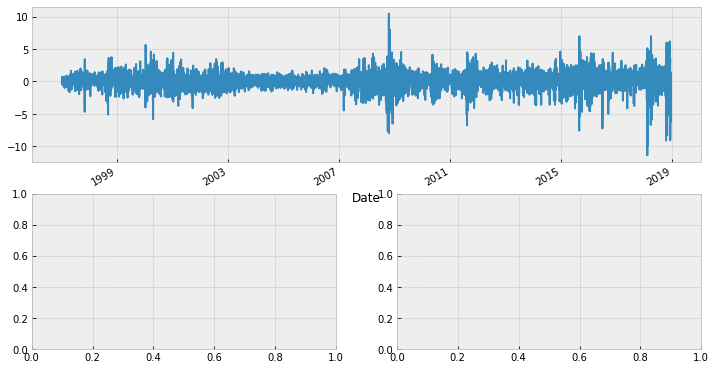

In [8]:
for n in [10,60,200]:       
    tsplot(df_price['Abs_Return'], lags=n)

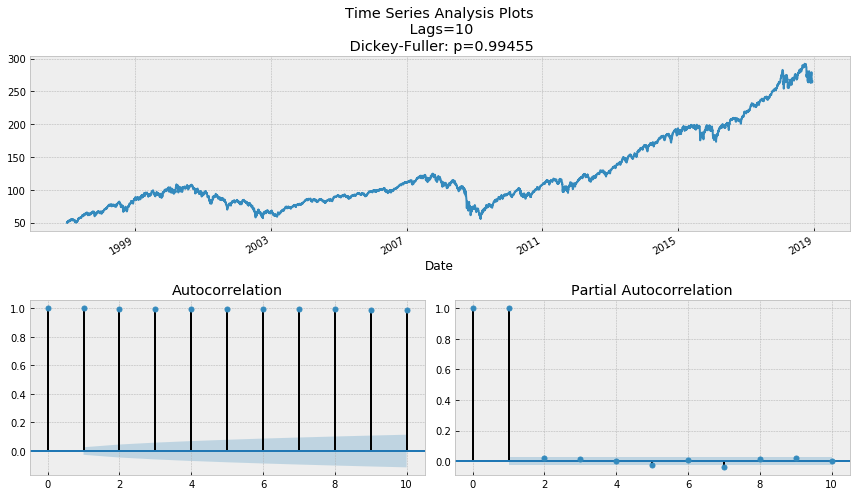

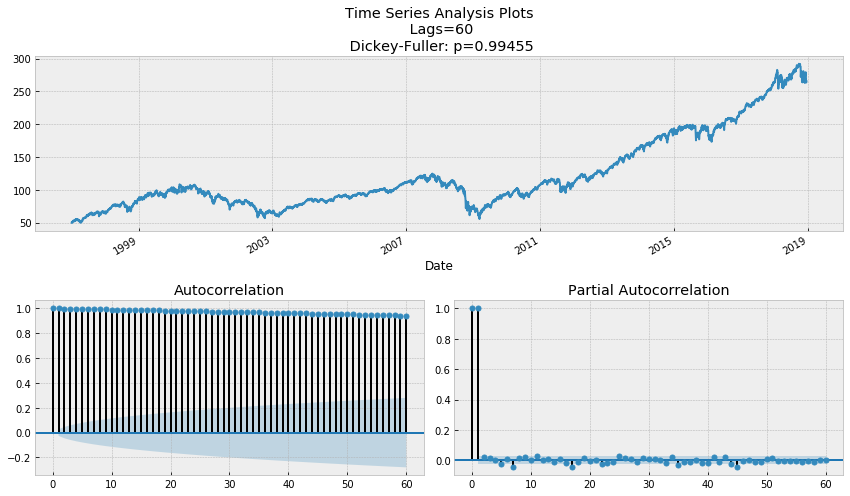

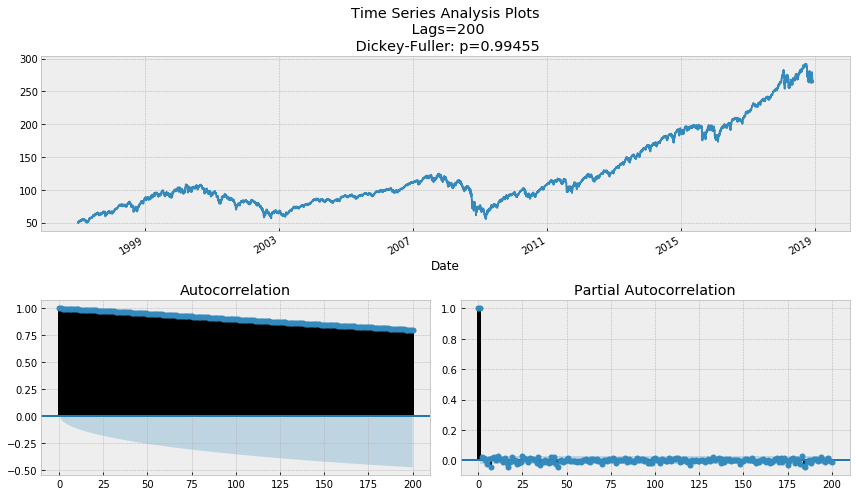

In [9]:
for n in [10,60,200]:       
    tsplot(df_price['Adj Close'], lags=n)

/anaconda2/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


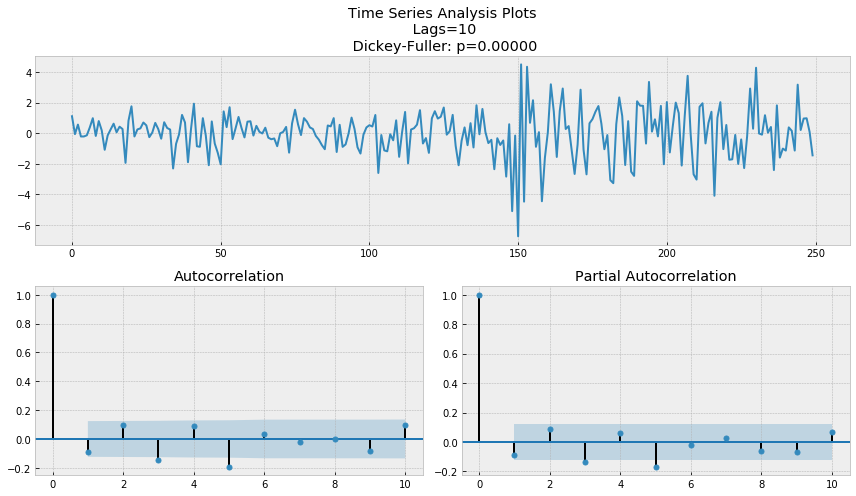

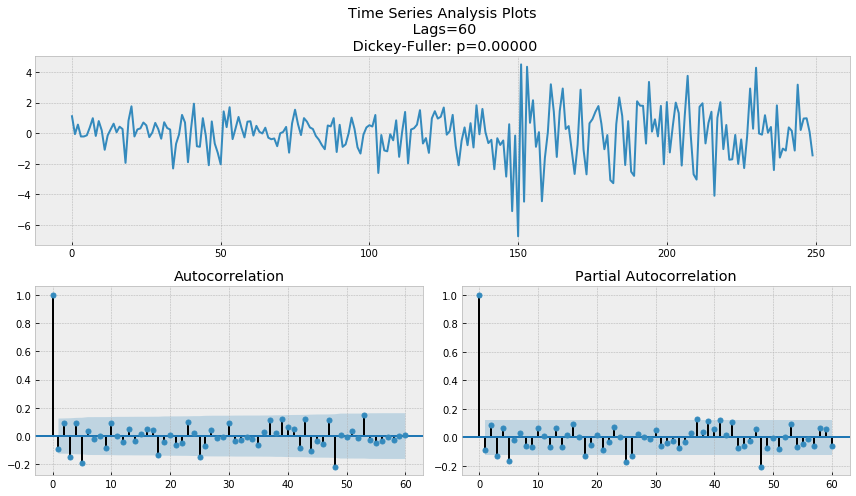

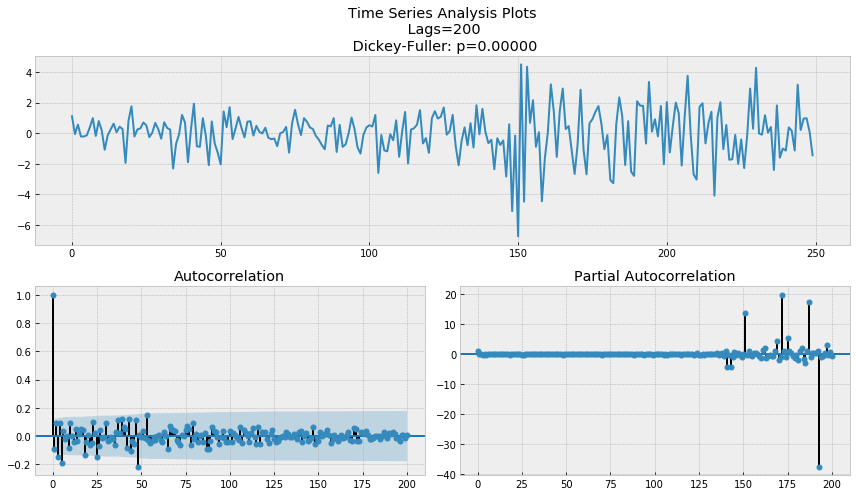

In [10]:
for n in [10,60,200]:       
    tsplot(df_price['Abs_Return'].values[-2000:-1750], lags=n)

In [11]:
# set the parameters that give the lowest AIC
p, d, q, P, D, Q ,s = 1,1,0,0,0,0,0

abs_model=sm.tsa.statespace.SARIMAX(df_price['Adj Close'], trend='n',order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit()
print(abs_model.summary())

                           Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                 5524
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -9316.731
Date:                Sun, 16 Dec 2018   AIC                          18637.463
Time:                        15:03:07   BIC                          18650.696
Sample:                             0   HQIC                         18642.078
                               - 5524                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0441      0.008     -5.702      0.000      -0.059      -0.029
sigma2         1.7090      0.016    110.232      0.000       1.679       1.739
Ljung-Box (Q):                      109.68   Jarque-

/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [12]:
exog_test = pd.Series(np.arange(1442), index=pd.DatetimeIndex(start='2015-01-01', end='2018-12-12', freq='D'))
pr = abs_model.predict(
    start=len(df_price['Adj Close'])-1442, end=len(df_price['Adj Close']), dynamic=False)

/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [13]:
df_res = pd.DataFrame(np.nan, index=pd.DatetimeIndex(start='2015-01-01', end='2018-12-12', freq='D'), columns=['Forecast'])
df_res['Forecast']=pr.to_frame().values[1:]
df_result = pd.concat([df_price, df_res], axis=1, join_axes=[df_price.index])
df_result.iloc[-10:]

,Adj Close,Log_Return,Abs_Return,Forecast
Date,,,,
2018-11-28,274.579987,0.022764,6.179993,264.339755
2018-11-29,273.980011,-0.002187,-0.599976,264.980274
2018-11-30,275.649994,0.006077,1.669983,263.328107
2018-12-03,279.299988,0.013155,3.649994,274.307273
2018-12-04,270.250000,-0.032939,-9.049988,274.006487
2018-12-06,269.839996,-0.001518,-0.410004,279.138919
2018-12-07,263.570007,-0.023510,-6.269989,270.649362
2018-12-10,264.070007,0.001895,0.500000,264.047943
2018-12-11,264.130005,0.000227,0.059998,264.127357


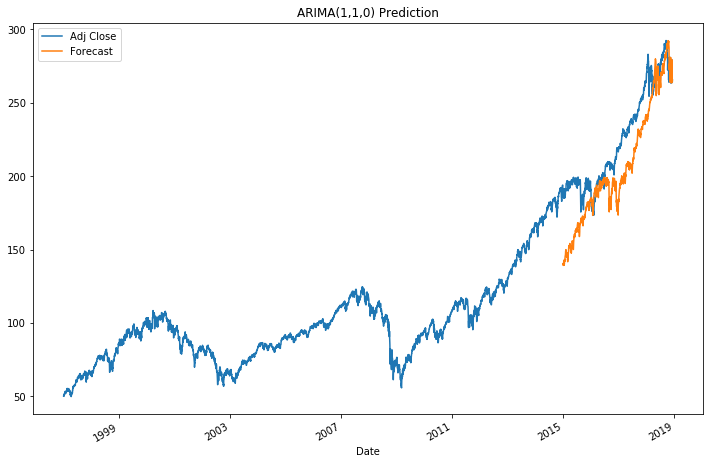

In [16]:
df_result[['Adj Close','Forecast']].plot(figsize=(12, 8), title="ARIMA(1,1,0) Prediction")

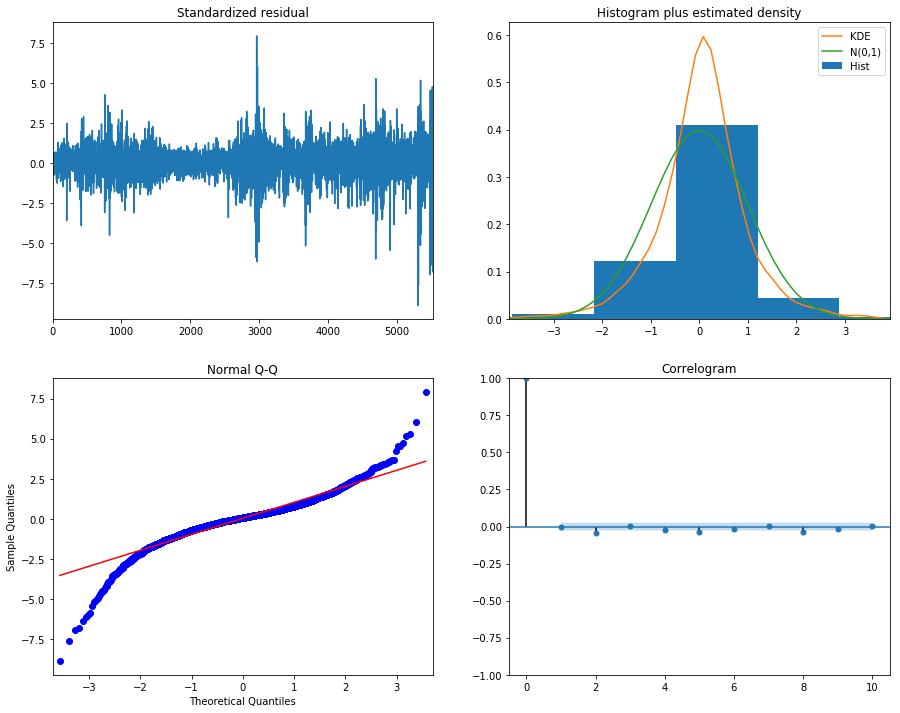

In [402]:
abs_model.plot_diagnostics(figsize=(15, 12))
plt.show()